# Get Vegetation Tree Height Polygons
Assign value for client name — this will label the reports.

Generate a token following the directions [here](https://ibm.github.io/Environmental-Intelligence-Suite/api-tokens.html) and paste the token into the quotes for `AUTH_TOKEN` below.

___

___

In [1]:
client = 'Demo'

In [2]:
AUTH_TOKEN = ''

___

## Import Libraries and Define Functions

In [3]:
import os
import json
import requests
from IPython.display import Image
from datetime import datetime as dt

In [4]:
API_ENDPOINT = 'foundation.agtech.ibm.com/v2'
os.environ["API_ENDPOINT"] = API_ENDPOINT
os.environ["AUTH_TOKEN"]= AUTH_TOKEN

ASSET_MGMT = {
    'host': os.environ.get('API_ENDPOINT', 'Run the notebook to set env vars')
}

HEADERS = {
    'Accept': 'application/json',
    'Authorization': 'Bearer ' + os.environ.get("AUTH_TOKEN", 'Run the notebook to set env vars'),
    'Content-Type': 'application/json; charset=UTF-8'
}

In [5]:
def getScalarType(scalar_type=None):
    get_url = 'https://{}/scalar/type'.format(ASSET_MGMT['host'])
    
    params = {}
    
    if scalar_type is not None:
        params['type'] = scalar_type
    
    r = requests.get(url=get_url, headers=HEADERS,  params=params) 
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()


def getHierarchy():
    get_url = 'https://{}/hierarchy'.format(ASSET_MGMT['host'])
    
    r = requests.get(url=get_url, headers=HEADERS)
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()


def _getAssetsBlock(params):
    get_url = 'https://{}/asset'.format(ASSET_MGMT['host'])
    r = requests.get(url=get_url, headers=HEADERS, params=params)

    if r.status_code == 200:
        return json.loads(r.text)
    else:
        r.raise_for_status()


def getAssets(input_type=None, parentID=None, limit=1000, idsOnly=False, includeScalars=False, includeGeom=False, showCount=True):

    assets = {
        'features': []
    }

    params = {
        'start': 0,
        'idsOnly': idsOnly,
        'includeAssetGeometry': includeGeom,
        'limit': limit,
        'projection': '4326'
    }

    if input_type is not None:
        params['inputType'] = input_type

    if parentID is not None:
        params['parentReferenceUuid'] = parentID

    if includeScalars is True:
        params['includeScalarInfo'] = includeScalars

    response = _getAssetsBlock(params)
    total_records = response["totalRecords"]
    assets['features'] = response['features']
    assets_loaded = len(assets['features'])

    if showCount:
        print('[{}] Assets from [{}] total'.format(assets_loaded, total_records))

    while assets_loaded < total_records:
        params['start'] = assets_loaded
        response = _getAssetsBlock(params)

        assets['features'].extend(response['features'])
        assets_loaded = len(assets['features'])

        if showCount:
            print('[{}] Assets from [{}] total'.format(assets_loaded, total_records))

    return assets


def search_vectordata_by_bounding_box(box, layer_id, start=0, limit=1000):

    params = {
        'matchMode': 'CONTAINS',
        'bufferSize': 100,
        'boundingBox': box,
        'start': start,
        'limit': limit,
        'layerId': layer_id
    }

    vector_uuids = set()
    vector_data = {
        'features': []
    }
    
    params = json.dumps(params)
    results = _get_vectordata_block(params)
    total_vectors_loaded = len(results['features'])

    # Discard any potential duplicates
    for vector in results['features']:
        if vector['uuid'] not in vector_uuids:
            vector_uuids.add(vector['uuid'])
            vector_data['features'].append(vector)

    # Perhaps still more to read
    if total_vectors_loaded == limit:
        while True:
            params = json.loads(params)
            params['start'] = int(total_vectors_loaded)
            params = json.dumps(params)
            
            results = _get_vectordata_block(params)
            vectors_loaded = len(results['features'])

            if vectors_loaded > 0:
                # Discard any potential duplicates
                for vector in results['features']:
                    if vector['uuid'] not in vector_uuids:
                        vector_uuids.add(vector['uuid'])
                        vector_data['features'].append(vector)

                total_vectors_loaded = total_vectors_loaded + vectors_loaded

            if vectors_loaded < limit:
                print('Final batch of vectors for given territory — total retrieved:', total_vectors_loaded)
                break
            else:
                print('Vectors retrieved so far:', total_vectors_loaded)

    return vector_data


def _get_vectordata_block(params):

    post_url = 'https://{}/vectordata/search/box'.format(ASSET_MGMT['host'])
    r = requests.post(url=post_url, data=params, headers=HEADERS)

    if r.status_code == 200:
        vector_data = r.json()
        return vector_data
    else:
        r.raise_for_status()


def get_vectordata_for_features(feature_collection, layer):

    all_vectors = {'features': []}
    all_vector_uuids = set()
    repeat_uuids = set()
    
    print('Initiating request to get all vector data...')

    for feature in feature_collection['features']:
        print('\nGetting vectors for territory:', feature['properties']['name'])
        bbox = feature['properties']['box']

        vector_data = search_vectordata_by_bounding_box(bbox, layer_id=layer)

        for vector in vector_data['features']:
            if vector['uuid'] not in all_vector_uuids:
                all_vector_uuids.add(vector['uuid'])
                all_vectors['features'].append(vector)
            else:
                repeat_uuids.add(vector['uuid'])

    print('Unique Vectors:', len(all_vectors['features']))
    print('Repeat Vectors:', len(repeat_uuids))

    return all_vectors

---

___

## Fetch Vegetation Polygons

### 1. First, get all territories

In [6]:
territories = getAssets('TERRITORY')

[2] Assets from [2] total


In [7]:
terr_count = 0
all_territories = []
for territory in territories['features']:
    all_territories.append(territory)
    print('Territory Name:',territory['properties']['name'])    
    print('Territory UUID:', territory['uuid'])
    print('Index:', terr_count)
    terr_count = terr_count + 1
    print('\n')

Territory Name: NAPERVILLE_NORTH
Territory UUID: fa601936-4ce8-4054-8e17-84b5746febd3
Index: 0


Territory Name: NAPERVILLE_SOUTH
Territory UUID: c33c5a6b-439a-4b91-96fd-d6f537ccc733
Index: 1




___

### 2. Get Vegetation for One Territory
The default here is getting data from the first territory in the list above; this can be changed by updating the numerical value in the brackets. First, we select the territory, then we find the bounding box for this territory.

In [8]:
single_territory = all_territories[0]
print('Territory selected:', single_territory['properties']['name'])

Territory selected: NAPERVILLE_NORTH


In [9]:
bounding_box = single_territory['properties']['box']
print(bounding_box)

{'north': 41.801992, 'south': 41.779182, 'east': -88.126626, 'west': -88.172316}


___

**Regular Vegetation**

Set layer=`VEGM-TH` to get the regular vegetation.

In [10]:
print('Getting vectors for:', single_territory['properties']['name'],'\n')
veg_polygons = search_vectordata_by_bounding_box(bounding_box, 'VEGM-TH')

Getting vectors for: NAPERVILLE_NORTH 

Final batch of vectors for given territory — total retrieved: 1201


Save vegetation data. Please specify filepath.

In [11]:
filepath = '../../../../Desktop/Veg _Polygons.geojson'

In [12]:
veg_polygons['type'] = 'FeatureCollection'
with open(filepath, 'w') as f:
    json.dump(veg_polygons, f)

___

**Fall-In Vegetation**

Set layer=`VEGM-FALLIN-TH` to get the fall-in vegetation.

In [13]:
print('Getting vectors for:', single_territory['properties']['name'],'\n')
fallin_vectors = search_vectordata_by_bounding_box(bounding_box, 'VEGM-FALLIN-TH')

Getting vectors for: NAPERVILLE_NORTH 



Save vegetation data. Please specify filepath.

In [14]:
fallin_filepath = '../../../../Desktop/FallIn_Polygons.geojson'

In [15]:
fallin_vectors['type'] = 'FeatureCollection'
with open(fallin_filepath, 'w') as f:
    json.dump(fallin_vectors, f)

___

___

### 3. Get Vector Data for All Territories

**Get vegetation data**

In [16]:
allVegPolygons = get_vectordata_for_features(territories, layer='VEGM-TH')

Initiating request to get all vector data...

Getting vectors for territory: NAPERVILLE_NORTH
Final batch of vectors for given territory — total retrieved: 1201

Getting vectors for territory: NAPERVILLE_SOUTH
Final batch of vectors for given territory — total retrieved: 1304
Unique Vectors: 2202
Repeat Vectors: 303


In [17]:
all_filepath = '../../../../Desktop/All_VegPolygons.geojson'

In [18]:
allVegPolygons['type'] = 'FeatureCollection'
with open(all_filepath, 'w') as f:
    json.dump(allVegPolygons, f)

___

**Get fall-in data**

In [19]:
allFallinPolygons = get_vectordata_for_features(territories, layer='VEGM-FALLIN-TH')

Initiating request to get all vector data...

Getting vectors for territory: NAPERVILLE_NORTH

Getting vectors for territory: NAPERVILLE_SOUTH
Unique Vectors: 614
Repeat Vectors: 87


In [20]:
all_fallin_filepath = '../../../../Desktop/All_FallInPolygons.geojson'

In [21]:
allFallinPolygons['type'] = 'FeatureCollection'
with open(all_fallin_filepath, 'w') as f:
    json.dump(allFallinPolygons, f)

___

___

## Visualize Results in QGIS
Drag and drop the output from `Get_Vegetation_Polygons.ipynb` and `Export_Report.ipynb` into QGIS to visualize the results. See example below.

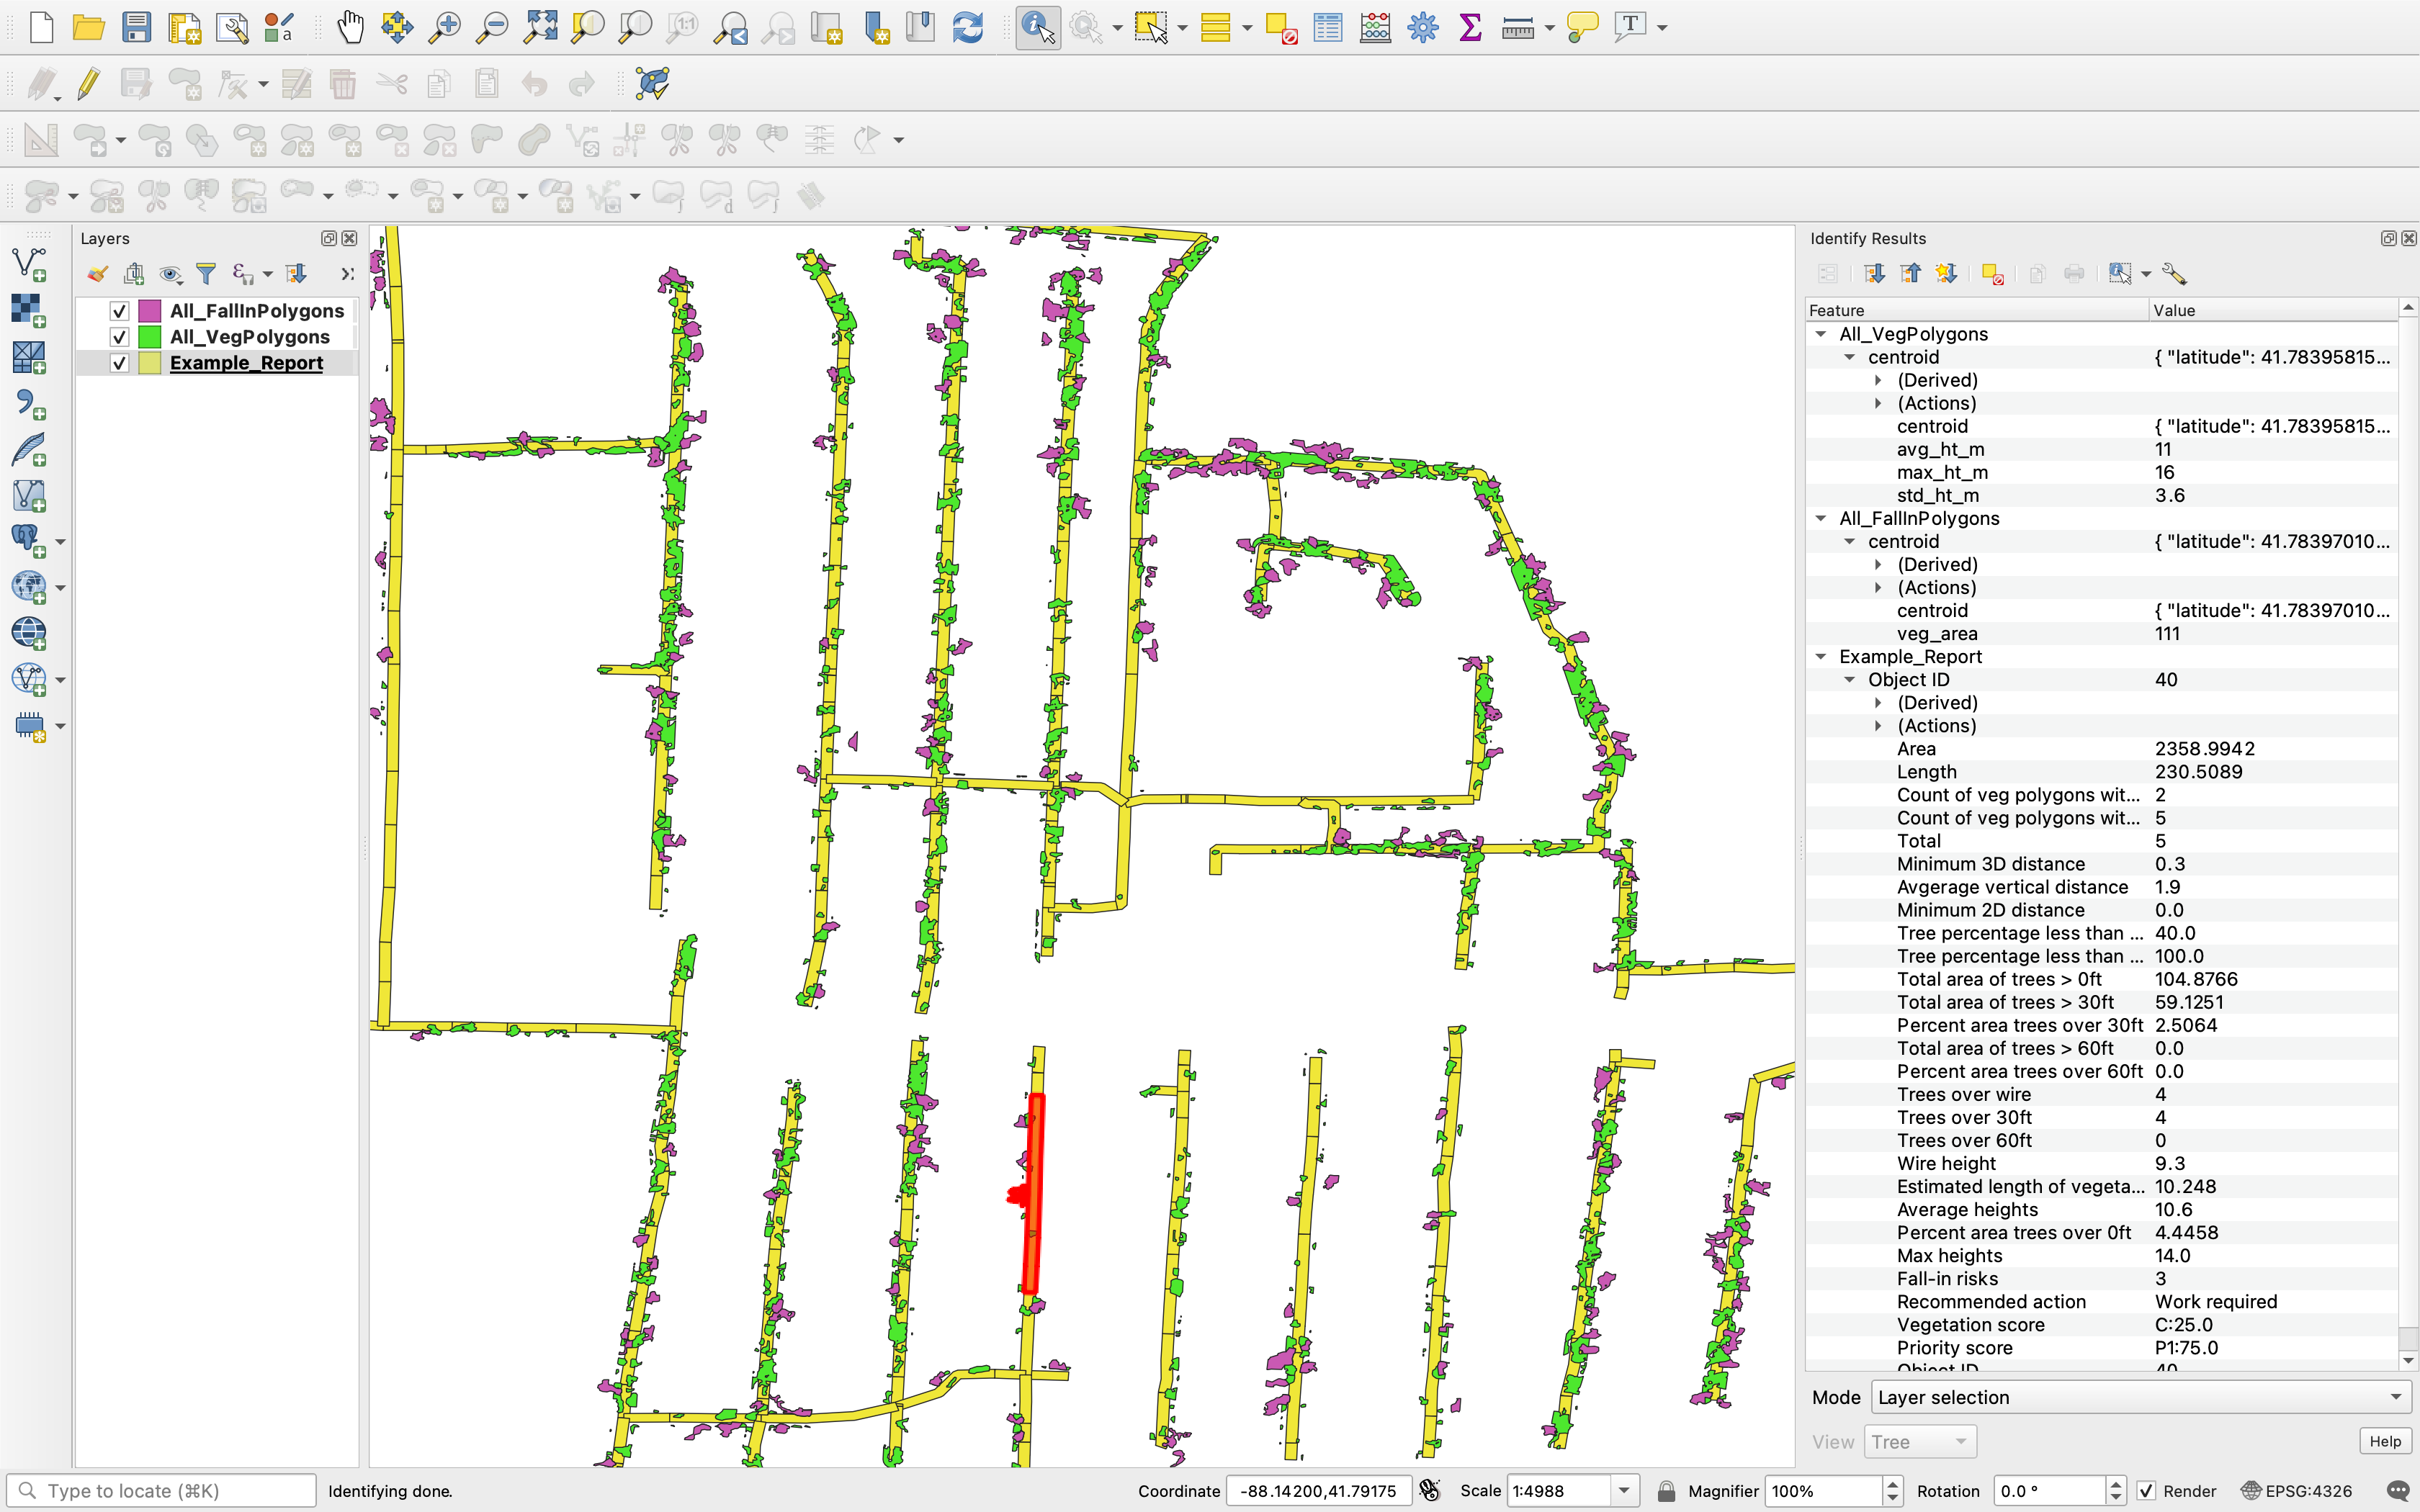

In [22]:
Image('Data/Demo KPIs and Vegetation.png')

___

___